In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import scipy.stats as stats
# Import data processing package
from DataProcessing import *
# Import plot packages
import gspplot
from gspplot import *
# Import graph packages
import gsp
from pygsp import graphs, filters, plotting, utils
# Import other packages
from Learning import *
from operator import itemgetter
import warnings; warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and Crop a Patch

In [2]:
path_cloud   = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud        = load_cloud(path_cloud)
newcloud     = cloud_preprocess(cloud)
# Crop a patch from cloud
patch1       = crop_patch(newcloud, (150, 300), (150, 300))
patch2       = crop_patch(newcloud, (200, 350), (50, 200))
intersection = crop_patch(newcloud, (200, 300), (150, 200))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 300], y:[150, 300].
=> Points left for patch: 157488.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[200, 350], y:[50, 200].
=> Points left for patch: 182404.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[200, 300], y:[150, 200].
=> Points left for patch: 46363.
----------------------------------------------------


## 1.2 Data Visualization

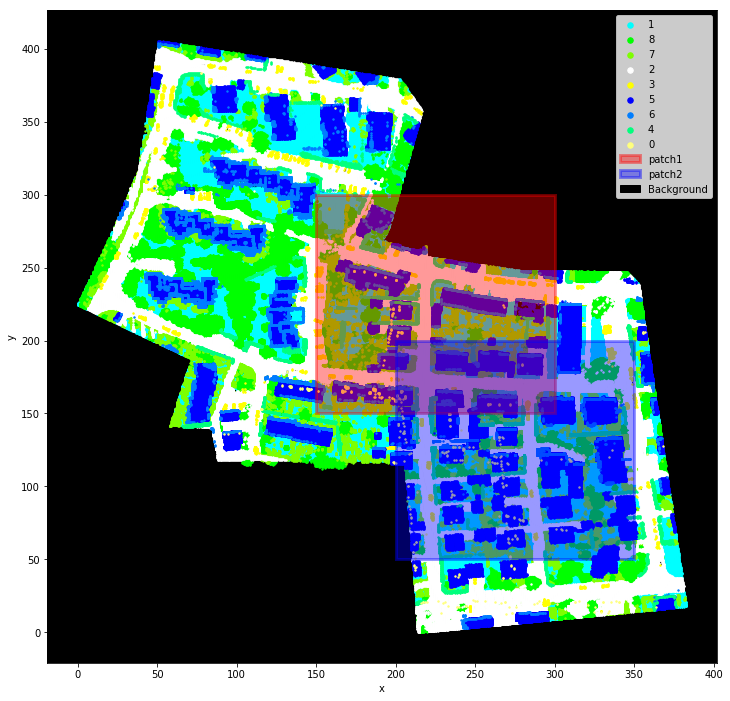

In [3]:
zones = np.array([[150, 300, 150, 300], 
                  [200, 350, 50, 200]])
zones_label = np.array([['red', 'patch1'], 
                        ['blue', 'patch2']])
gspplot.plot_vaihingen_2D_zones(newcloud, zones, zones_label)

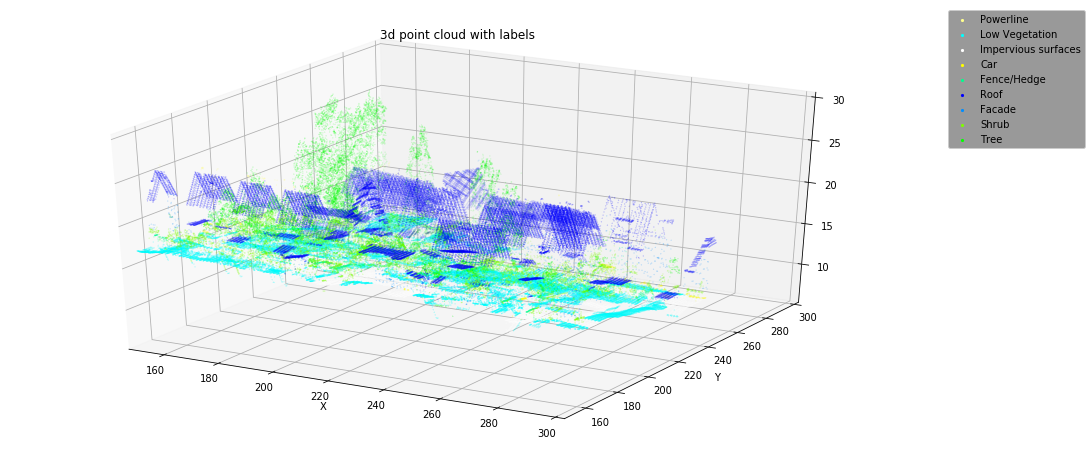

In [4]:
plot_graph_3D(patch1, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(150, 300), 
              yRange=(150, 300))

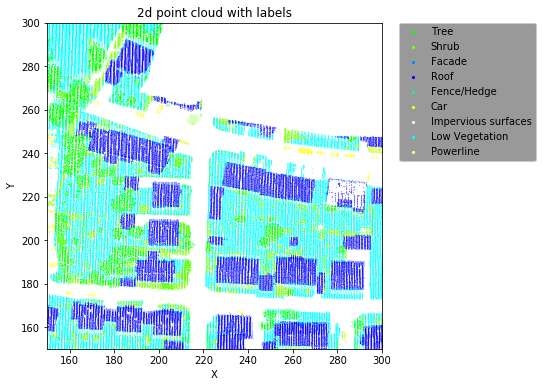

In [5]:
plot_graph_2D(patch1, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(150, 300), 
              yRange=(150, 300))

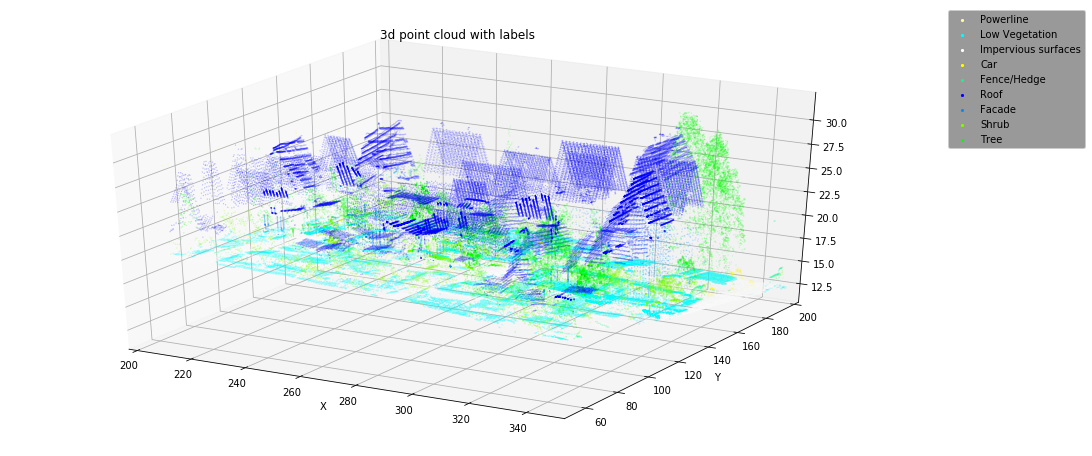

In [6]:
plot_graph_3D(patch2, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(200, 350), 
              yRange=(50 , 200))

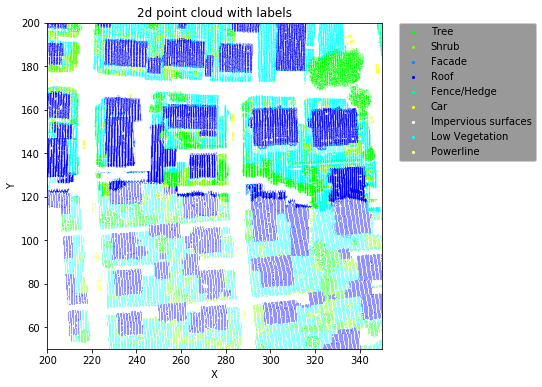

In [7]:
plot_graph_2D(patch2, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(200, 350), 
              yRange=(50 , 200))

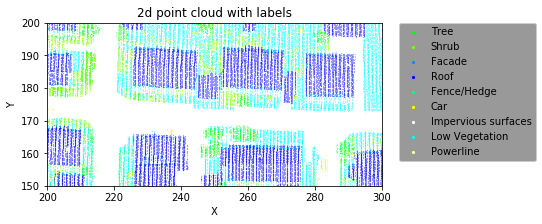

In [8]:
plot_graph_2D(intersection, 
              figsize=(6,3), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(200, 300), 
              yRange=(150, 200))

# 2 Graph Construction 

## 2.1 Generating Graph

Five types of graph are generated in the following way:  
1) When type is '30nn', connect 30 nearest neighbors of a particular node.  
2) When type is 'r101', connect neighbors within the radius of 1.1.  

Then, it remains to calculate the weights:  
1) Gaussian: Use Euclidean distance. Weight is calculated by: $$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{2\sigma^2} \right)$$  
Where $\sigma$ is the mean value of all distances.

2) Binary: Set all weights to be 1 if connected.

3) Local: Comparing to Gaussian, only $\sigma$ changes here.$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma_i \sigma_j} \right)$$  
Where $\sigma_i$ is the distance between node $i$ and its farthest neighbor, the same for node $j$.



### Use the Number of Neighbors

In [9]:
# 30nn, Gaussian kernel
G_30nn_Gaussain1 = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='distance', neightype='number', lap_type='combinatorial')
# 30nn, Binary graph
G_30nn_Binary1   = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='connectivity', neightype='number', lap_type='combinatorial')
# 30nn, Local scaling
G_30nn_Local1    = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='local', neightype='number', lap_type='combinatorial')

In [10]:
# 30nn, Gaussian kernel
G_30nn_Gaussain2 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='distance', neightype='number', lap_type='combinatorial')
# 30nn, Binary graph
G_30nn_Binary2   = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='connectivity', neightype='number', lap_type='combinatorial')
# 30nn, Local scaling
G_30nn_Local2    = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                                 mode='local', neightype='number', lap_type='combinatorial')

### Use the Radius to Find Neighbors

In [11]:
# r1.1, Gassian kernel
G_r101_Gaussain1 = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='distance', neightype='radius', lap_type='combinatorial')
# r1.1, Binary graph
G_r101_Binary1   = gsp.knn_graph(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='connectivity', neightype='radius', lap_type='combinatorial')

In [12]:
# r1.1, Gassian kernel
G_r101_Gaussain2 = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='distance', neightype='radius', lap_type='combinatorial')
# r1.1, Binary graph
G_r101_Binary2   = gsp.knn_graph(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False, 
                                 mode='connectivity', neightype='radius', lap_type='combinatorial')

## 2.2  Gaussian Kernel Visualization

In [13]:
# Get a list a distance for each Gaussian graph
_, dists1 = gsp.knn_w(cloud=patch1[['x', 'y', 'z']], k=30, dist3D=False, 
                      mode='distance', neightype='number')
_, dists2 = gsp.knn_w(cloud=patch1[['x', 'y', 'z']], r=1.1, dist3D=False, 
                      mode='distance', neightype='radius')
_, dists3 = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], k=30, dist3D=False, 
                      mode='distance', neightype='number')
_, dists4 = gsp.knn_w(cloud=patch2[['x', 'y', 'z']], r=1.1, dist3D=False,
                      mode='distance', neightype='radius')
dists     = [dists1, dists2, dists3, dists4]

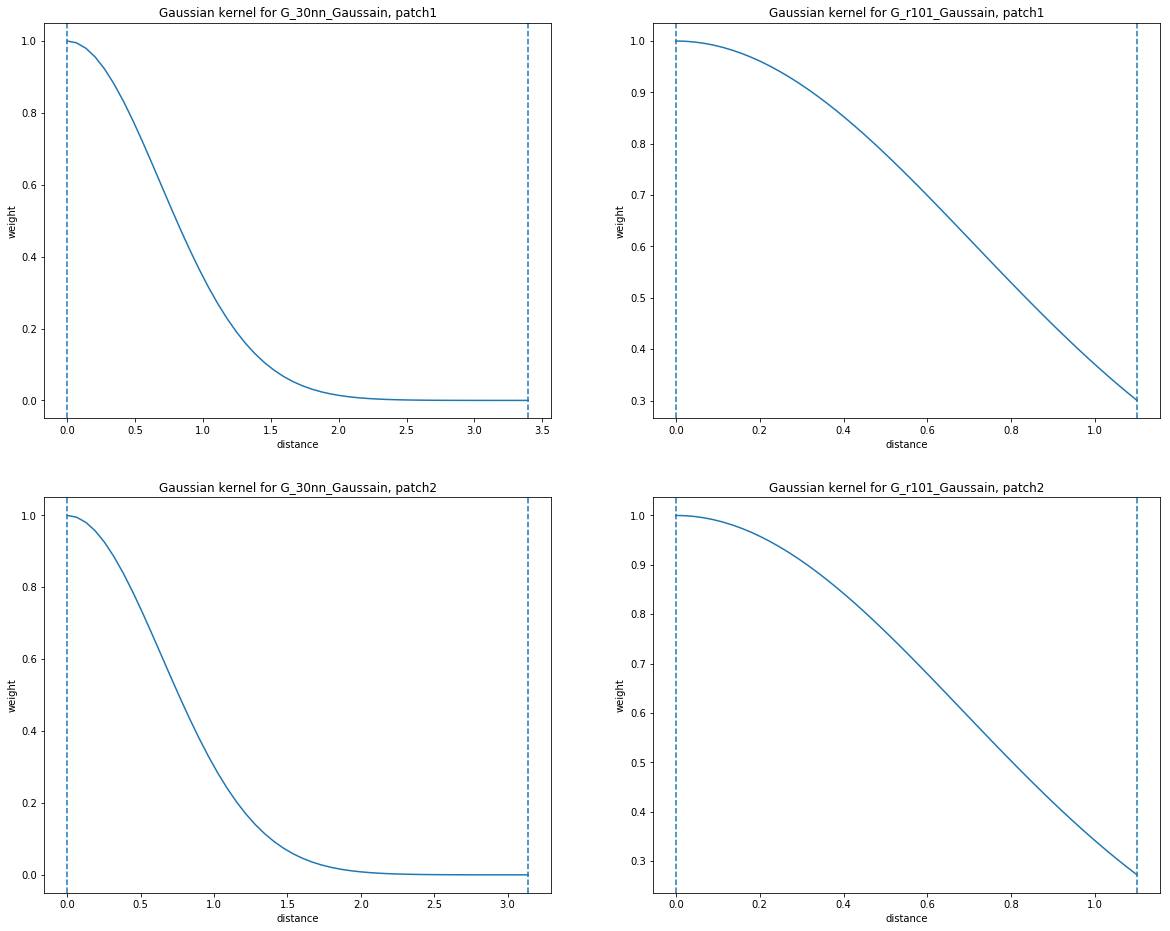

In [14]:
# Weight-Distance Plot
tmp        = [np.array(i) for i in dists]
s          = [np.mean(i[i!=0]) for i in tmp]
d_max      = [np.max(i) if j%2 == 0 else 1.1 for i, j in zip(dists, range(4))]
d_min      = [np.min(i) for i in dists]
title_list = ['Gaussian kernel for G_30nn_Gaussain, patch1',
              'Gaussian kernel for G_r101_Gaussain, patch1',
              'Gaussian kernel for G_30nn_Gaussain, patch2',
              'Gaussian kernel for G_r101_Gaussain, patch2']

# Plot Gaussian kernel
fig, axes  = plt.subplots(2, 2, figsize=(20, 16))
for i in range(4):
    ax = axes[i//2, i%2]
    x = np.linspace(d_min[i], d_max[i], 50)
    y = s[i]*np.sqrt(2*np.pi)*stats.norm.pdf(x, 0, s[i])
    ax.plot(x, y)
    ax.set_xlabel('distance')
    ax.set_ylabel('weight')
    ax.axvline(x=d_min[i], linestyle='--')
    ax.axvline(x=d_max[i], linestyle='--')
    ax.set_title(title_list[i])

# 3 POI detection

## 3.1 Mexican Hat Filter Construction

In [15]:
# Create graph list
graph_list  = [G_30nn_Gaussain1, G_30nn_Binary1, G_30nn_Local1, G_r101_Gaussain1, G_r101_Binary1,
               G_30nn_Gaussain2, G_30nn_Binary2, G_30nn_Local2, G_r101_Gaussain2, G_r101_Binary2]

# Initialize filters dictionary
filter_dict = dict.fromkeys(['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local', 
                             'g_MH_r101_Gaussain', 'g_MH_r101_Binary'])

for i, idx in zip(filter_dict.keys(), range(5)):
    filter_dict[i] = []
    if 'nn' in i:
        filter_dict[i].append(filters.MexicanHat(graph_list[idx], Nf=1+len([0.04]), lpfactor=1, scales=[0.04]))
        filter_dict[i].append(filters.MexicanHat(graph_list[idx+5], Nf=1+len([0.04]), lpfactor=1, scales=[0.04]))
    else:
        filter_dict[i].append(filters.MexicanHat(graph_list[idx], Nf=1+len([0.01]), lpfactor=1, scales=[0.01]))
        filter_dict[i].append(filters.MexicanHat(graph_list[idx+5], Nf=1+len([0.01]), lpfactor=1, scales=[0.01]))             

## 3.2 Visualization Filters

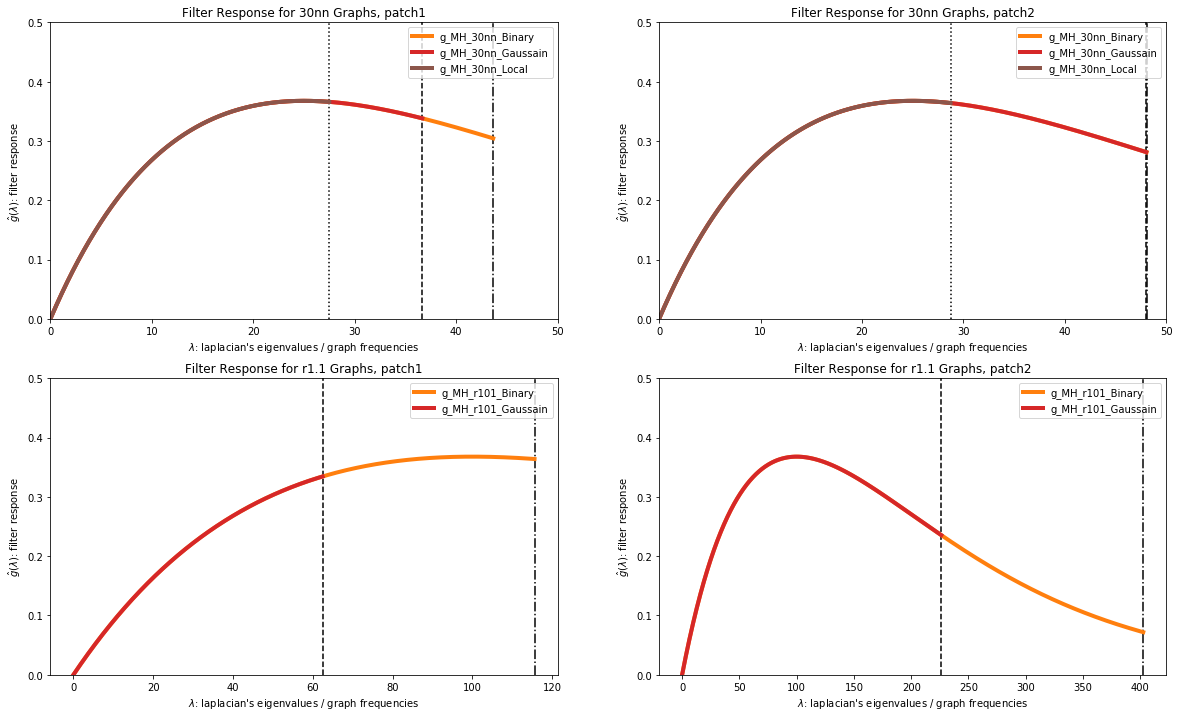

In [16]:
title_list = ['Filter Response for 30nn Graphs, patch1',
              'Filter Response for 30nn Graphs, patch2',
              'Filter Response for r1.1 Graphs, patch1',
              'Filter Response for r1.1 Graphs, patch2']

# Visualize filters
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
for k in range(4):
    ax = axes[k//2, k%2]
    if k < 2:
        for i,j in zip(itemgetter(*[1, 0, 2])(list(filter_dict.keys())), range(3)):
            filter_dict[i][k].plot(ax=ax, show_sum=False)
            ax.lines.pop(j)
        ax.set_xlim(0, 50)
        ax.set_ylim(0, 0.5)
        ax.vlines(graph_list[0+k*5].lmax, 0, 0.5, 'k', '--')
        ax.vlines(graph_list[1+k*5].lmax, 0, 0.5, 'k', '-.')
        ax.vlines(graph_list[2+k*5].lmax, 0, 0.5, 'k', ':')
        ax.set_title(title_list[k])
        ax.legend(itemgetter(*[1, 0, 2])(list(filter_dict.keys())))
    else:
        for i,j in zip(itemgetter(*[4, 3])(list(filter_dict.keys())), range(2)):
            filter_dict[i][k%2].plot(ax=ax, show_sum=False)
            ax.lines.pop(j)
        ax.set_ylim(0, 0.5)
        ax.vlines(graph_list[3+(k-2)*5].lmax, 0, 0.5, 'k', '--')
        ax.vlines(graph_list[4+(k-2)*5].lmax, 0, 0.5, 'k', '-.')
        ax.set_title(title_list[k])
        ax.legend(itemgetter(*[4, 3])(list(filter_dict.keys())))

Although the last filter seems like a bandpass filter, but actually it is fine, which can been seen later.

## 3.3 POI Detection and Visualization

In [17]:
threshold_nn = [0.2, 0.2, 0.2]
threshold_r  = [0.1, 0.1]

# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_30nn_Binary', 's_30nn_Local',
                             's_r101_Gaussain', 's_r101_Binary'])
# Create edge index dictonary, highlight nodes that have high frequency
edge_dict   = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                             'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i, j, k, m in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys(), range(5)):
    signal_dict[i] = []
    edge_dict[k] = []
    signal_dict[i].append(filter_dict[j][0].filter(patch1.z, method = 'chebyshev'))
    signal_dict[i].append(filter_dict[j][1].filter(patch2.z, method = 'chebyshev'))
    if 'nn' in i:
        edge_dict[k].append(signal_dict[i][0][:, -1] >= threshold_nn[m])
        edge_dict[k].append(signal_dict[i][1][:, -1] >= threshold_nn[m])
    else:
        edge_dict[k].append(signal_dict[i][0][:, -1] >= threshold_r[m-3])
        edge_dict[k].append(signal_dict[i][1][:, -1] >= threshold_r[m-3])

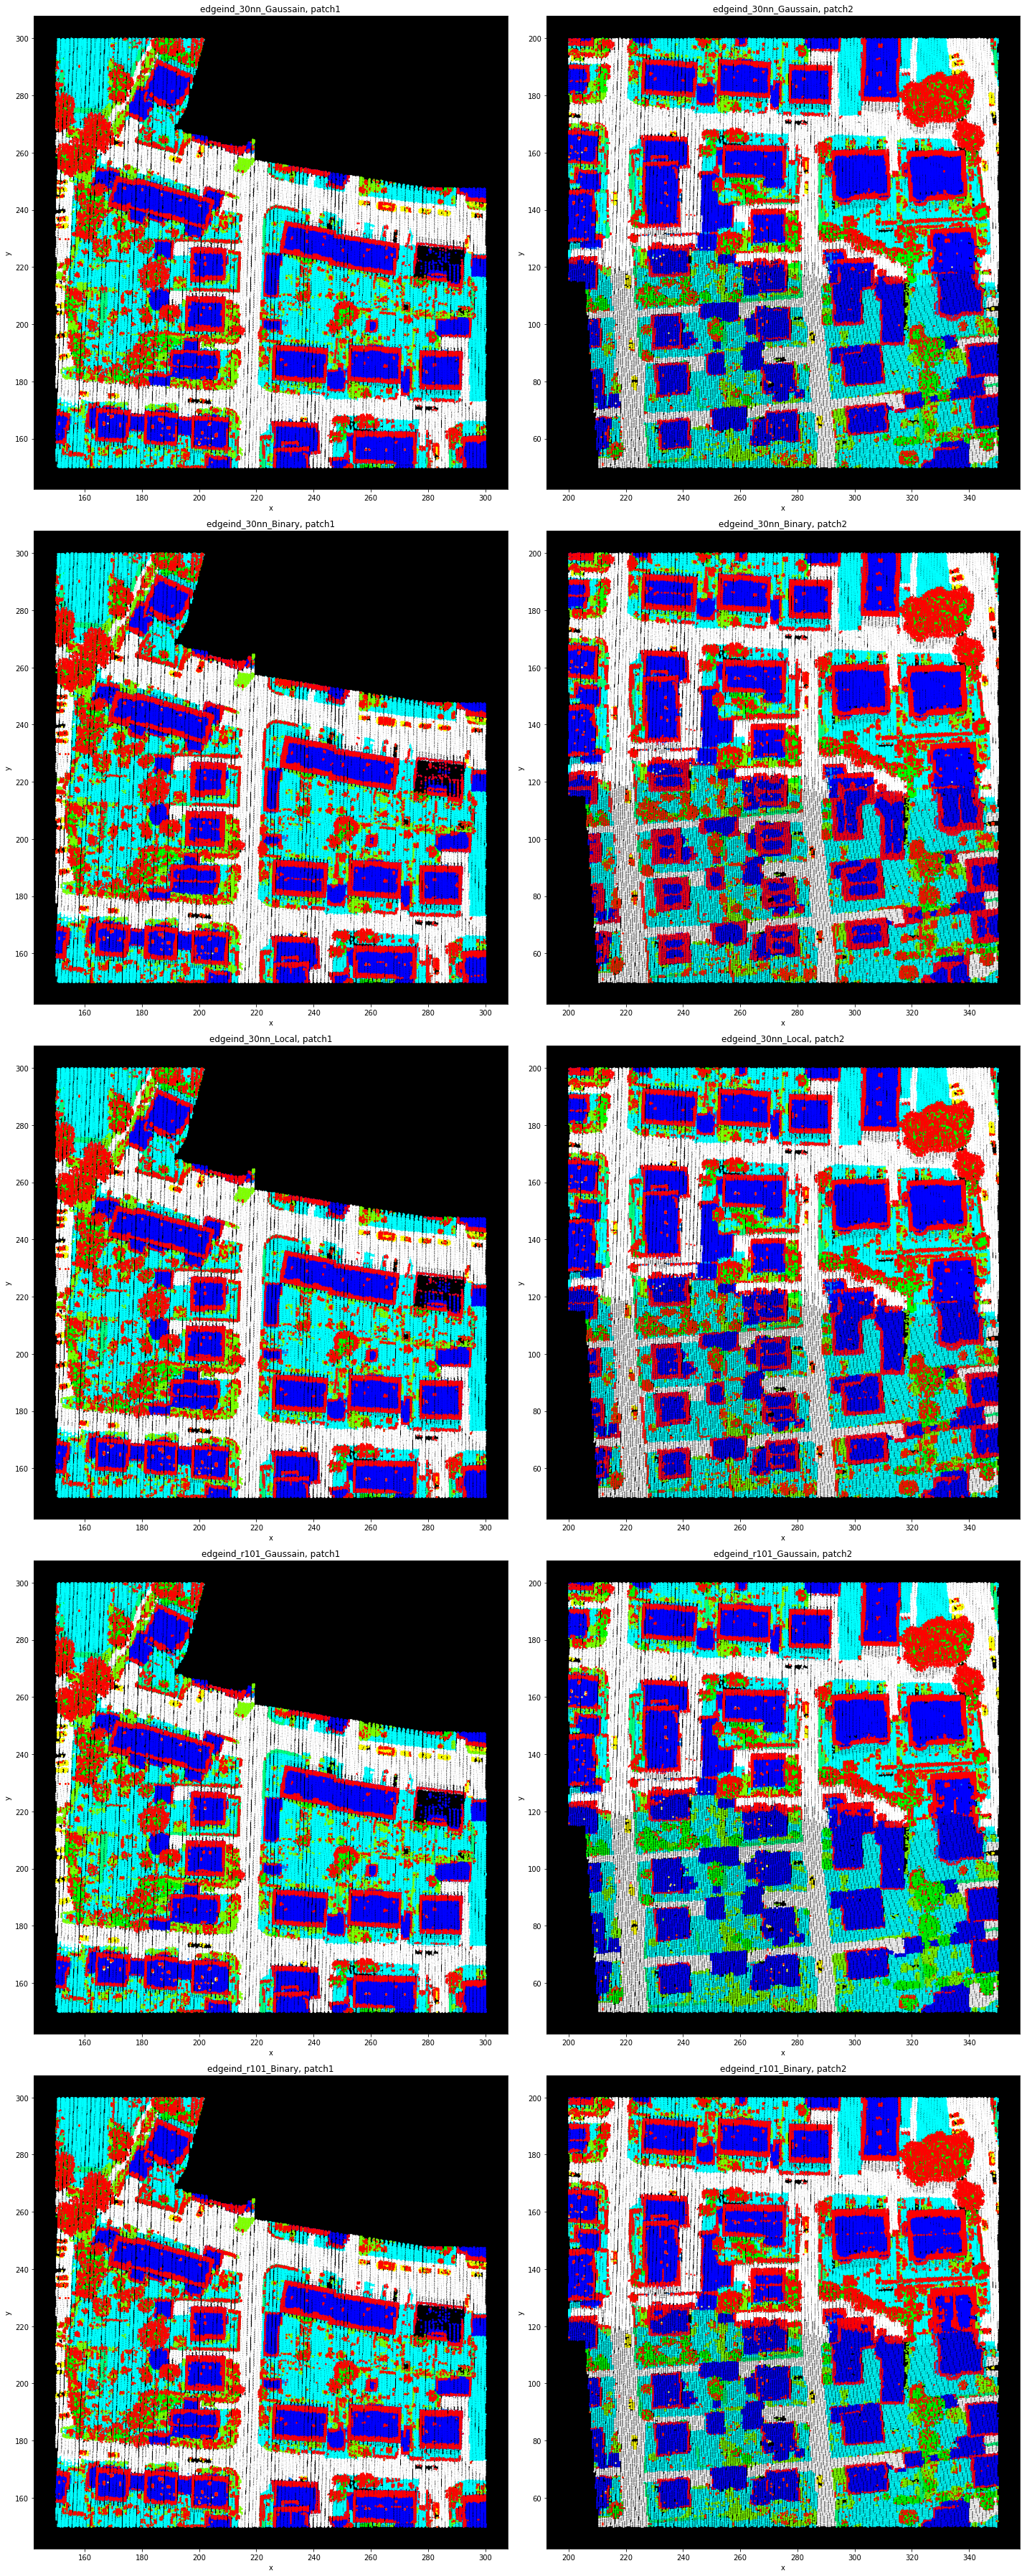

In [19]:
patch     = [patch1, patch2]
fig, axes = plt.subplots(5, 2, figsize=(20, 50))
for i, k in zip([val for val in edge_dict.keys() for _ in (0, 1)], range(10)):               
    if 'nn' in i:
        gspplot.plot_vaihingen_2D(patch[k%2], 
                                  id_highlight=np.nonzero(edge_dict[i][k%2])[0], 
                                  ax=axes[k//2,k%2], 
                                  label_high='Edges', 
                                  title="{}, patch{}".format(i,k%2+1))
    else:
        gspplot.plot_vaihingen_2D(patch[k%2], 
                                  id_highlight=np.nonzero(edge_dict[i][k%2])[0], 
                                  ax=axes[k//2,k%2], 
                                  label_high='Edges', 
                                  title="{}, patch{}".format(i, k%2+1))
plt.tight_layout()

30nn binary graph and 30nn local graph csn cure unequal point density distribution, while other types of graph detect thicker roof edges in the dense area but thinner ones in the sparse area.

## 3.4 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

But the problem is that some points in the body of the buildings come out. They seem to surround the powerline points. So I do the following procedures: 1) If the nodes belong to roofs or powerlines, set the signal to be 1. 2) Remove the positive false points after filtering the signal. We cannot delete those powerline points in the dataframe because the indices are changed in this way. 

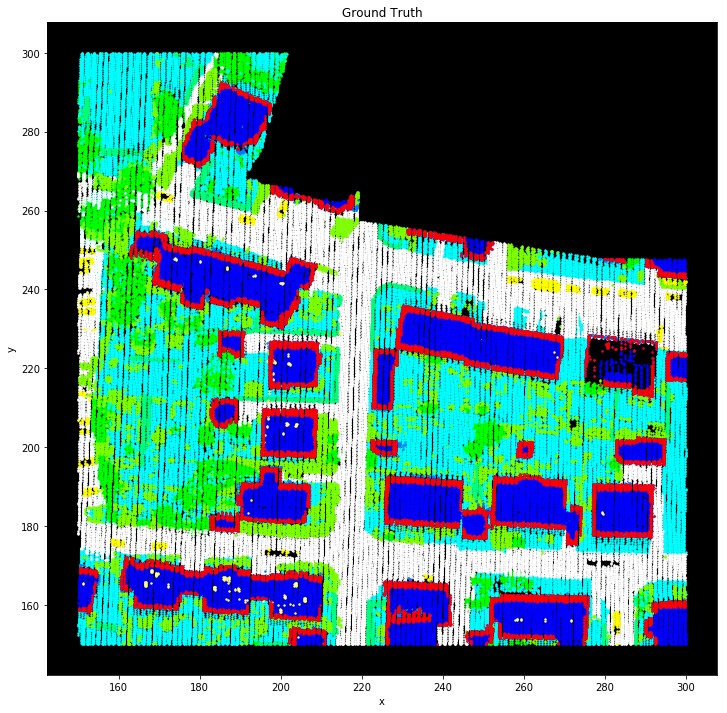

In [20]:
df_patch1, edge_roof1 = set_ground_truth(patch=patch1, 
                                         threshold=0.08, 
                                         f=filter_dict['g_MH_30nn_Binary'][0], 
                                         figsize=(12, 12))

It is very hard to remove gambling roof, because we start to lose other edge points if incresing the threshlod.

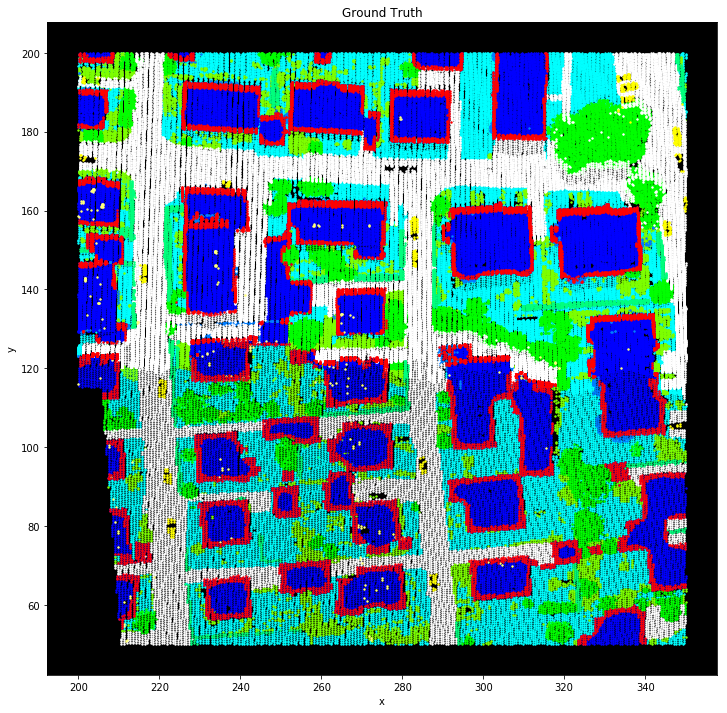

In [21]:
df_patch2, edge_roof2 = set_ground_truth(patch=patch2, 
                                         threshold=0.08, 
                                         f=filter_dict['g_MH_30nn_Binary'][1], 
                                         figsize=(12, 12))

In [22]:
# Obtain points of interest in the intersection part of the two patches
df_intersect = df_patch1[df_patch1['index'].isin(list(intersection.index))]
df_intersect.reset_index(drop=True, inplace=True)
intersect_points  = list(df_patch1[df_patch1['index'].isin(list(intersection.index))].index)
intersection_roof = edge_roof1[intersect_points]
intersection_edge_dict = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_30nn_Binary', 'edgeind_30nn_Local',
                                        'edgeind_r101_Gaussain', 'edgeind_r101_Binary'])

for i in intersection_edge_dict.keys():
    intersection_edge_dict[i] = []
    tmp1 = edge_dict[i][0][intersect_points]
    tmp2 = edge_dict[i][1][list(df_patch2[df_patch2['index'].isin(list(intersection.index))].index)]
    intersection_edge_dict[i].extend((tmp1, tmp2))

## 3.5 Graph Quantitative Comparison

The tables below shows what the highligted points are composed of in each type of the graph. The column named total calculte the total number of points that come out after filtering in each graph representation. Other columns like precision and recall are calculated in the following way:

Precision = $\frac{detected\ points\ \cap \ GT}{detected\ points}$  
Recall (reference to ground truth) = $\frac{detected\ points\ \cap \ GT}{GT}$  
Recall (reference to label) = $\frac{detected\ points\ \cap \ roof points}{roof\ points}$

Table for patch1 

In [23]:
qua_comp_df(df =comp_df(patch1, edge_dict=edge_dict, labels=labels, num=0),
            df2=df_patch1,
            num=0,
            edge_roof=edge_roof1, 
            edge_dict=edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.006137        0.017379             0.001580  0.020296   
r101_Binary     0.006415        0.022136             0.001683  0.015911   
30nn_Local      0.006905        0.015307             0.001607  0.016549   
30nn_Gaussain   0.007153        0.013928             0.001476  0.012225   
r101_Gaussain   0.006970        0.009818             0.001148  0.006630   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.051773  0.425880  0.011059  0.146234  0.319661  32913   
r101_Binary       0.050116  0.394925  0.012958  0.161622  0.334233  31487   
30nn_Local        0.042670  0.407957  0.013919  0.146787  0.348299  27373   
30nn_Gaussain     0.040952  0.413724  0.013588  0.141819  0.355134  26421   
r101_Gaussain     0.031408  0.425432  0.015385  0.124782  0.378427  23529   

               Precision  Recall_GT  Recall_roof  
30nn_Binary     0.288184   0.837232     0.379125  
r101_Binary     0.293010   0.814370     0.336336  
30nn_Local      0.325503   0.786477     0.302039  
30nn_Gaussain   0.332463   0.775355     0.295656  
r101_Gaussain   0.351481   0.729985     0.270745

Table for patch2

In [24]:
qua_comp_df(df =comp_df(patch2, edge_dict=edge_dict, labels=labels, num=1),
            df2=df_patch2,
            num=1,
            edge_roof=edge_roof2, 
            edge_dict=edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.005470        0.016098             0.002032  0.009221   
30nn_Local      0.006421        0.015416             0.002384  0.005976   
r101_Binary     0.005449        0.017072             0.000825  0.005649   
30nn_Gaussain   0.007061        0.013094             0.000781  0.002768   
r101_Gaussain   0.005702        0.009470             0.000467  0.001634   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.045427  0.512516  0.033550  0.096429  0.279258  38391   
30nn_Local        0.039827  0.473253  0.043196  0.107403  0.306125  31461   
r101_Binary       0.043016  0.505199  0.041542  0.097705  0.283543  40008   
30nn_Gaussain     0.035237  0.479330  0.044853  0.094887  0.321990  28181   
r101_Gaussain     0.032376  0.504185  0.051849  0.082825  0.311493  29991   

               Precision  Recall_GT  Recall_roof  
30nn_Binary     0.329296   0.853324     0.332685  
30nn_Local      0.370300   0.786365     0.251746  
r101_Binary     0.272371   0.735538     0.341748  
30nn_Gaussain   0.381782   0.726223     0.228396  
r101_Gaussain   0.317662   0.643064     0.255668

Table for the intersection part evaluated on patch1

In [25]:
qua_comp_df(df =comp_df(intersection, edge_dict=intersection_edge_dict, labels=labels, num=0),
            df2=df_intersect,
            num=0,
            edge_roof=intersection_roof, 
            edge_dict=intersection_edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
r101_Binary     0.005125        0.052448             0.001636  0.005125   
30nn_Binary     0.004980        0.047473             0.001907  0.007841   
30nn_Local      0.005567        0.042942             0.001988  0.005964   
30nn_Gaussain   0.005707        0.037913             0.001631  0.005571   
r101_Gaussain   0.004992        0.022841             0.000756  0.004084   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
r101_Binary       0.046015  0.575183  0.014175  0.147312  0.152982   9171   
30nn_Binary       0.046837  0.605807  0.012080  0.121967  0.151107   9437   
30nn_Local        0.028231  0.607820  0.015639  0.130683  0.161166   7545   
30nn_Gaussain     0.026226  0.619649  0.014948  0.125696  0.162658   7359   
r101_Gaussain     0.021631  0.647103  0.017244  0.115565  0.165784   6611   

               Precision  Recall_GT  Recall_roof  
r101_Binary     0.423291   0.871772     0.338771  
30nn_Binary     0.410724   0.870424     0.367157  
30nn_Local      0.492114   0.833820     0.294522  
30nn_Gaussain   0.504280   0.833371     0.292852  
r101_Gaussain   0.536833   0.796991     0.274742

Table for the intersection part evaluated on patch2

In [26]:
qua_comp_df(df =comp_df(intersection, edge_dict=intersection_edge_dict, labels=labels, num=1),
            df2=df_intersect,
            num=1,
            edge_roof=intersection_roof, 
            edge_dict=intersection_edge_dict)

Powerline  Low Vegetation  Impervious surfaces       Car  \
r101_Binary     0.005122        0.052528             0.001635  0.005013   
30nn_Binary     0.005010        0.047756             0.001812  0.007568   
30nn_Local      0.005716        0.043068             0.001861  0.005849   
30nn_Gaussain   0.005887        0.035324             0.001682  0.005046   
r101_Gaussain   0.004820        0.020989             0.000777  0.004042   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
r101_Binary       0.046534  0.575850  0.014276  0.147232  0.151809   9176   
30nn_Binary       0.044985  0.606119  0.012152  0.123334  0.151263   9381   
30nn_Local        0.027117  0.607869  0.015685  0.131862  0.160973   7523   
30nn_Gaussain     0.024110  0.624615  0.015559  0.124895  0.162882   7134   
r101_Gaussain     0.021766  0.649720  0.017724  0.113495  0.166667   6432   

               Precision  Recall_GT  Recall_roof  
r101_Binary     0.422951   0.871547     0.339349  
30nn_Binary     0.412536   0.869077     0.365166  
30nn_Local      0.492623   0.832248     0.293687  
30nn_Gaussain   0.514158   0.823714     0.286173  
r101_Gaussain   0.544776   0.786885     0.268384

From the tables above, we know that 30nn binary graph and 30nn local graph have comparable performance on patch 1 and patch 2. We can have similar performances for all types of graph when evaluated on patch1 or on patch2.